In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
import re
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
all_df = pd.read_csv('all_players_df.csv')
gk_df= pd.read_csv('gk_df.csv')
cb_df= pd.read_csv('cb_df.csv')
fb_df= pd.read_csv('fb_df.csv')
dm_df= pd.read_csv('dm_df.csv')
cm_df= pd.read_csv('cm_df.csv')
am_df= pd.read_csv('am_df.csv')
wf_df= pd.read_csv('wf_df.csv')
st_df= pd.read_csv('st_df.csv')

In [3]:
all_df['Transfer Value'] = all_df['Transfer Value'].fillna(0)
all_df['Wage'] = all_df['Wage'].fillna(0)
all_df['Last Trans. Fee'] = all_df['Last Trans. Fee'].fillna(0)
all_df['Av Rat'] = pd.to_numeric(all_df['Av Rat'], errors='coerce')
all_df['Av Rat'] = all_df['Av Rat'].fillna(6.7)

date_derived_features = ['Days Until Expiry', 'Age_at_Signing', 'Years_at_Club']

for col in date_derived_features:
    all_df[col] = all_df[col].fillna(0)

print(f"NaNs in 'Days Until Expiry' after filling: {all_df['Days Until Expiry'].isna().sum()}")

missing_values_count = all_df.isna().sum()
columns_with_nan = missing_values_count[missing_values_count > 0]
print("Columns with NaN values and their counts:")
print(columns_with_nan)

NaNs in 'Days Until Expiry' after filling: 0
Columns with NaN values and their counts:
Expires     108
Begins       73
Inf        3413
dtype: int64


In [4]:
pd.set_option('display.max_columns', None)

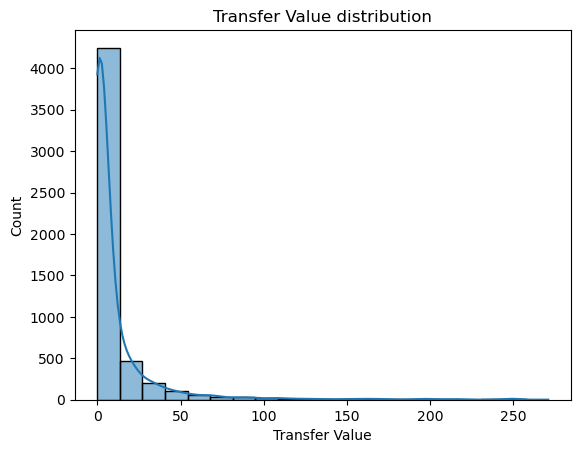

In [5]:
sns.histplot(data = all_df, x = 'Transfer Value', bins = 20, kde = True)
plt.title("Transfer Value distribution")
plt.show()

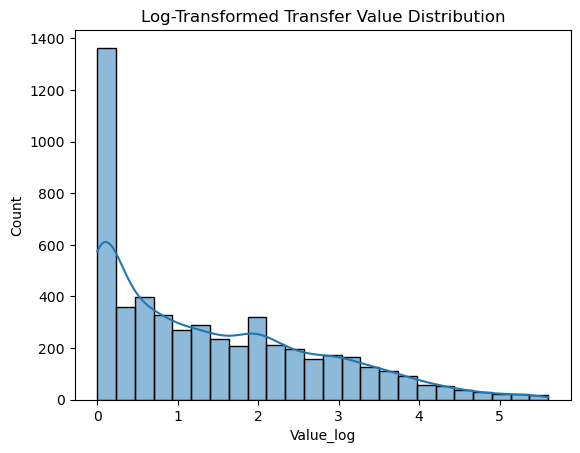

In [6]:
all_df['Value_log'] = np.log1p(all_df['Transfer Value'])

sns.histplot(all_df['Value_log'], kde=True)
plt.title('Log-Transformed Transfer Value Distribution')
plt.show()

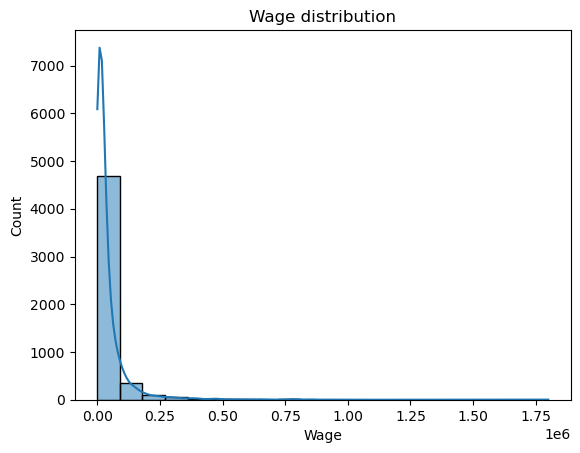

In [7]:
sns.histplot(data = all_df, x = 'Wage', bins = 20, kde = True)
plt.title("Wage distribution")
plt.show()

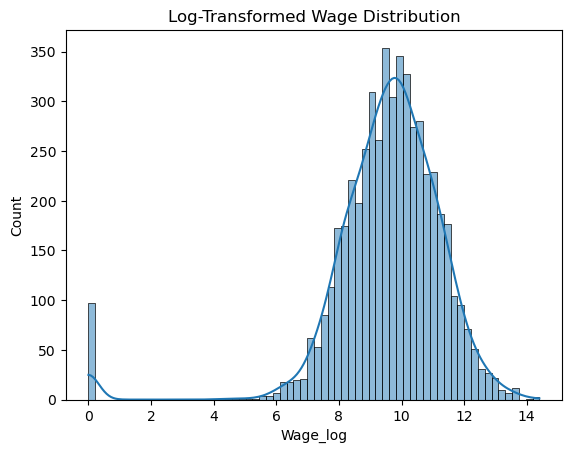

In [8]:
all_df['Wage_log'] = np.log1p(all_df['Wage'])

# Plot the new distribution to see the improvement
sns.histplot(all_df['Wage_log'], kde=True)
plt.title('Log-Transformed Wage Distribution')
plt.show()

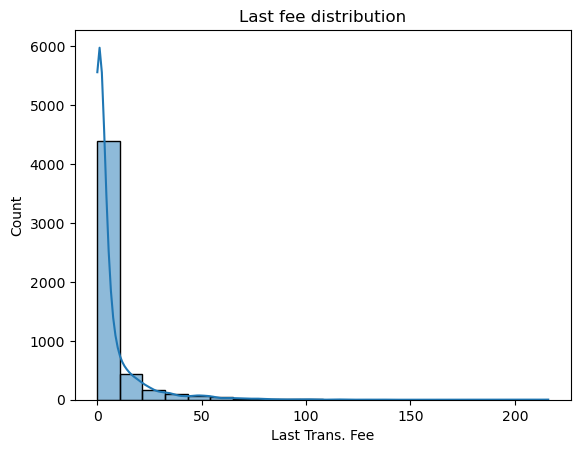

In [9]:
sns.histplot(data = all_df, x = 'Last Trans. Fee', bins = 20, kde = True)
plt.title("Last fee distribution")
plt.show()

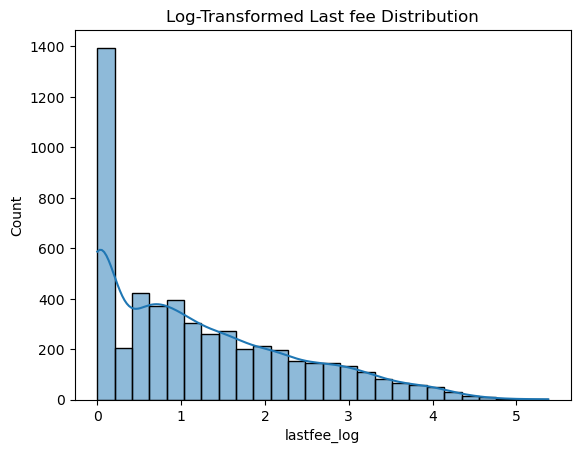

In [10]:
all_df['lastfee_log'] = np.log1p(all_df['Last Trans. Fee'])

# Plot the new distribution to see the improvement
sns.histplot(all_df['lastfee_log'], kde=True)
plt.title('Log-Transformed Last fee Distribution')
plt.show()

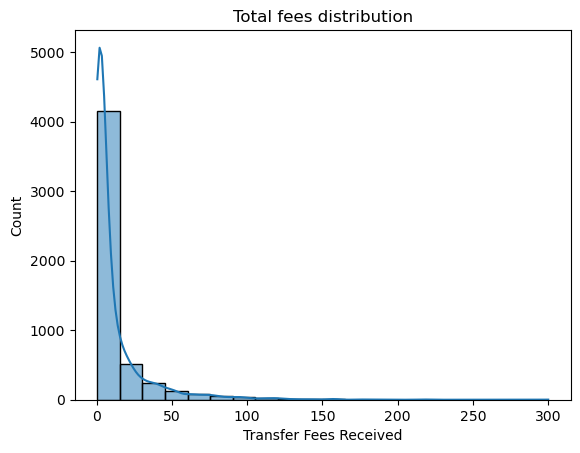

In [11]:
sns.histplot(data = all_df, x = 'Transfer Fees Received', bins = 20, kde = True)
plt.title("Total fees distribution")
plt.show()

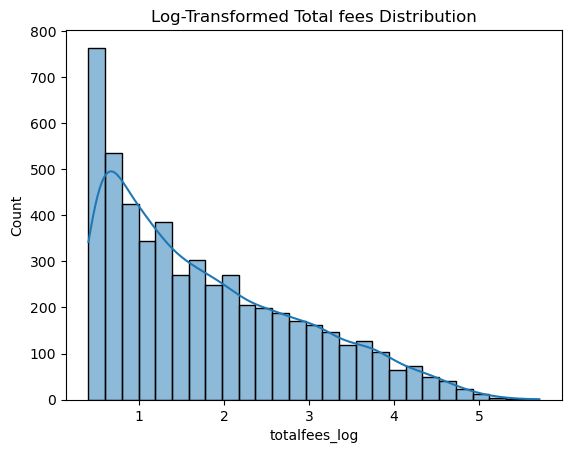

In [12]:
all_df['totalfees_log'] = np.log1p(all_df['Transfer Fees Received'])

# Plot the new distribution to see the improvement
sns.histplot(all_df['totalfees_log'], kde=True)
plt.title('Log-Transformed Total fees Distribution')
plt.show()

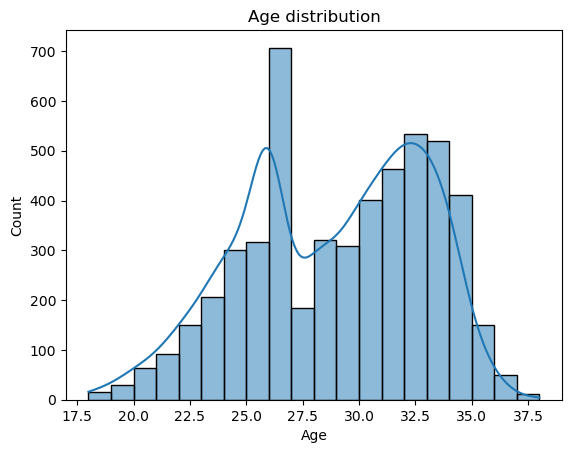

In [13]:
sns.histplot(data = all_df, x = 'Age', bins = 20, kde = True)
plt.title("Age distribution")
plt.show()

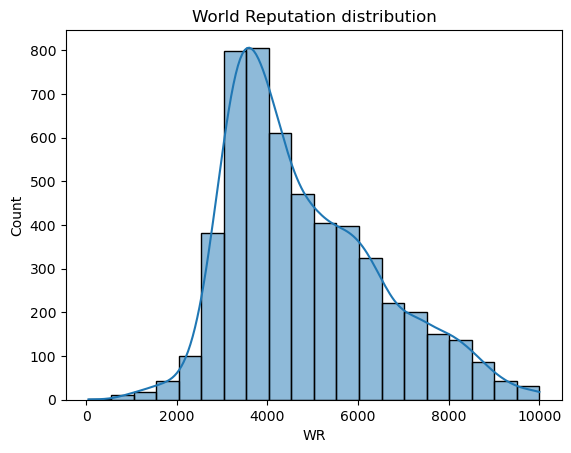

In [14]:
sns.histplot(data = all_df, x = 'WR', bins = 20, kde = True)
plt.title("World Reputation distribution")
plt.show()

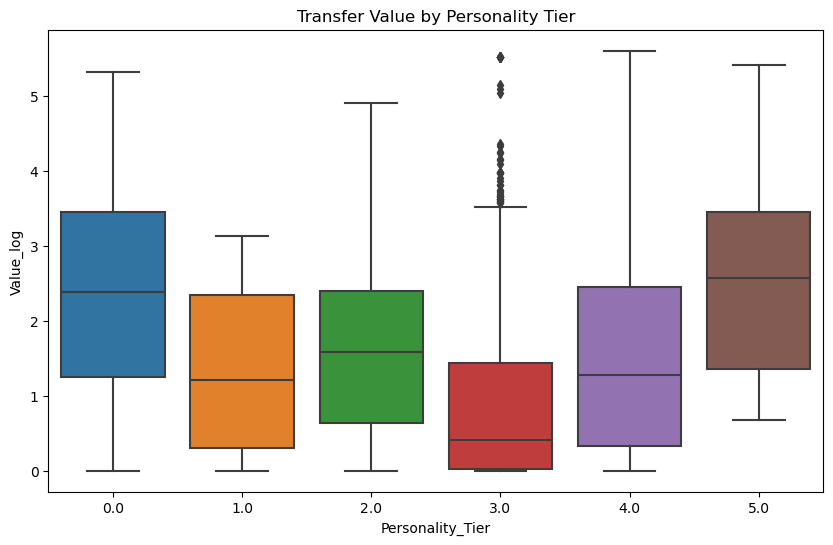

In [15]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(data=all_df, x='Personality_Tier', y='Value_log')
plt.title('Transfer Value by Personality Tier')
plt.show()

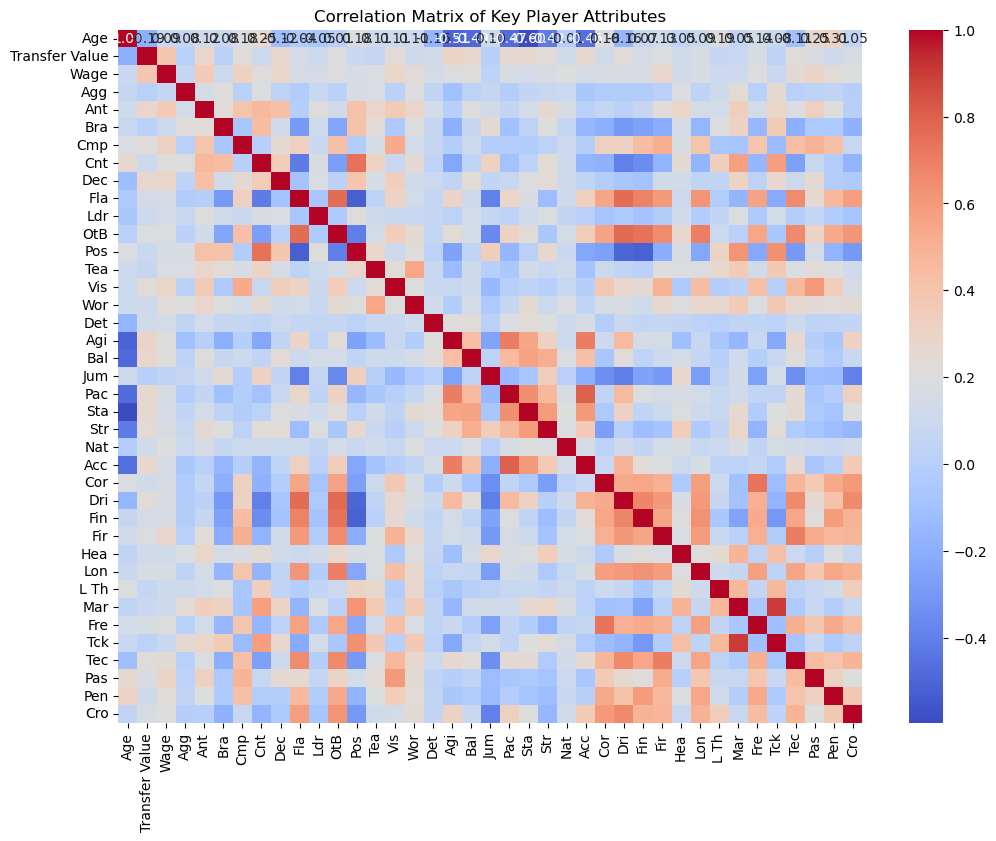

In [16]:
numerical_cols = ['Age', 'Transfer Value', 'Wage', 'Agg','Ant','Bra','Cmp','Cnt','Dec','Fla','Ldr','OtB','Pos','Tea','Vis','Wor','Det','Agi','Bal','Jum','Pac','Sta','Str','Nat','Acc','Cor','Dri','Fin','Fir','Hea','Lon','L Th','Mar','Fre','Tck','Tec' ,'Pas','Pen','Cro']
corr_matrix = all_df[numerical_cols].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Player Attributes')
plt.show()

In [17]:
#target
y = all_df['Value_log']

excluded = ['Name', 'Personality', 'Transfer Value', 'Value_log', 'Expires', 'Begins', 'Based', 'Division', 'Apps', 'Wage', 'Last Trans. Fee', 'Inf', 'Transfer Status', 'Rec', 'Country']
x = all_df.drop(columns = excluded)

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler
numerical_features = x_train.select_dtypes(include=np.number).columns[x_train.select_dtypes(include=np.number).max() > 1]

scaler = StandardScaler()
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.transform(x_test[numerical_features])

In [20]:
lm = LinearRegression().fit(x_train, y_train)
y_pred_log = lm.predict(x_test)

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

print("--- Performance on Log-Transformed Scale ---")
print(f"R-squared (R²): {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae_log:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_log:.3f}")
print("-" * 45)

y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_log)

is_finite = np.isfinite(y_pred_original)

mae_original = mean_absolute_error(y_test_original[is_finite], y_pred_original[is_finite])
inf_predictions_count = np.isinf(y_pred_original).sum()
print(f"Number of infinite predictions found and excluded: {inf_predictions_count}")

print("\n--- Performance on Original Scale (in Millions) ---")
print(f"Mean Absolute Error (MAE): £{mae_original:.2f}M")

--- Performance on Log-Transformed Scale ---
R-squared (R²): -290326758206760484864.000
Mean Absolute Error (MAE): 1415233295.708
Root Mean Squared Error (RMSE): 23090749709.802
---------------------------------------------
Number of infinite predictions found and excluded: 4

--- Performance on Original Scale (in Millions) ---
Mean Absolute Error (MAE): £7.13M


C:\Users\ziadb\AppData\Local\Temp\ipykernel_13708\2575651225.py:17: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.expm1(y_pred_log)


The R^2 value is blown up in the negative direction because when the log transformation was reversed, a prediction was too large for the float64 data type to handle. I had the code ignore these infinite predictions to see the R^2 value, but it is clear that a linear model is not the right model type for this data.

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest. 100 is a good starting point.
# n_jobs=-1 uses all available CPU cores to speed up training.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on your (un-scaled) training data
rf_model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [23]:
y_pred_log_rf = rf_model.predict(x_test)

r2_rf = r2_score(y_test, y_pred_log_rf)
print("--- Random Forest Performance on Log-Transformed Scale ---")
print(f"R-squared (R²): {r2_rf:.3f}")

y_test_original = np.expm1(y_test)
y_pred_original_rf = np.expm1(y_pred_log_rf)

mae_original_rf = mean_absolute_error(y_test_original, y_pred_original_rf)
print("\n--- Random Forest Performance on Original Scale (in Millions) ---")
print(f"Mean Absolute Error (MAE): £{mae_original_rf:.2f}M")

--- Random Forest Performance on Log-Transformed Scale ---
R-squared (R²): 0.764

--- Random Forest Performance on Original Scale (in Millions) ---
Mean Absolute Error (MAE): £5.38M


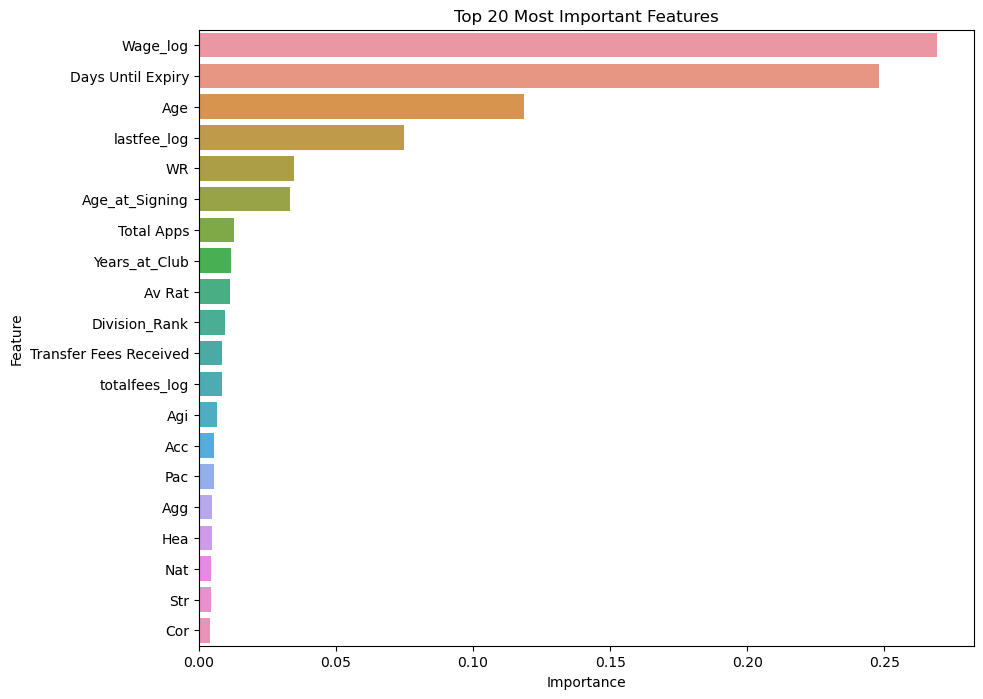

In [24]:
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Features')
plt.show()

The features with the highest importance make sense, as wage, contract length remaining, and age directly correlate to transfer value. A player with a high wage has already shown quality and importance, and it shows a big commitment from the club paying the wages. They would not want to let the player go easily. As a player's contract winds down,  the club's negotiating power decreases as the contract gets closer to expiry, which would allow a player to go to another club for free. A younger player commands a higher fee as they have potential to develop and more years of high-level performance. The on-field attributes which show on this plot are mostly physical attributes, which corresponds to a Football Manager community consensus that the most game-breaking attributes were the physical attributes.  

In [25]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2']       # Number of features to consider at every split
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=50,          # Number of parameter settings that are sampled
    cv=3,               # 3-fold cross-validation
    verbose=2,         
    random_state=42,
    n_jobs=-1        
)

rf_random_search.fit(x_train, y_train)

print("\nBest parameters found:")
print(rf_random_search.best_params_)

best_rf = rf_random_search.best_estimator_
y_pred_log_best_rf = best_rf.predict(x_test)

y_test_original = np.expm1(y_test)
y_pred_original_best_rf = np.expm1(y_pred_log_best_rf)

mae_original_best_rf = mean_absolute_error(y_test_original, y_pred_original_best_rf)
print("\n--- Tuned Random Forest Performance on Original Scale ---")
print(f"New Mean Absolute Error (MAE): £{mae_original_best_rf:.2f}M")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

--- Tuned Random Forest Performance on Original Scale ---
New Mean Absolute Error (MAE): £6.55M


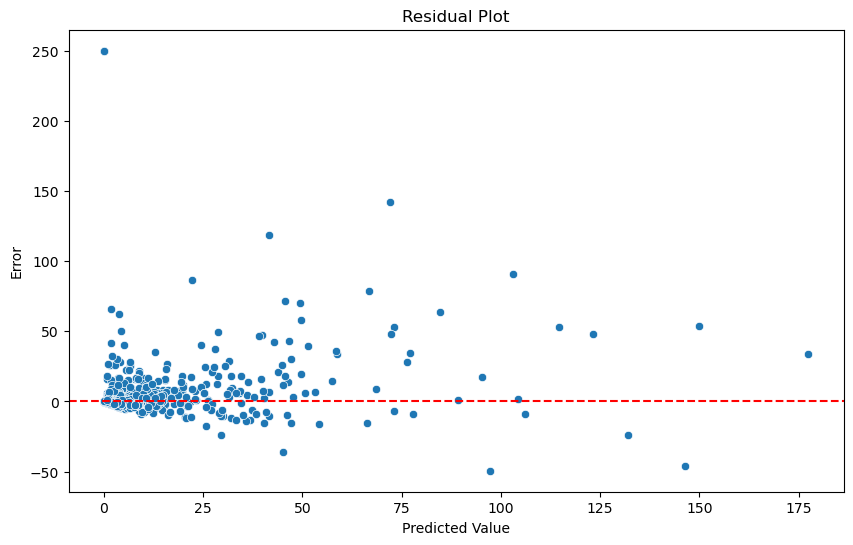

In [26]:
# untuned model had best result
y_pred_log_rf = rf_model.predict(x_test)
y_pred_original_rf = np.expm1(y_pred_log_rf)

residuals = y_test_original - y_pred_original_rf

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_original_rf, y=residuals)
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Residual Plot')
plt.xlabel('Predicted Value')
plt.ylabel('Error')
plt.show()

In [27]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

xgb_model.fit(x_train, y_train)

y_pred_log_xgb = xgb_model.predict(x_test)

y_test_original = np.expm1(y_test)
y_pred_original_xgb = np.expm1(y_pred_log_xgb)

mae_xgb = mean_absolute_error(y_test_original, y_pred_original_xgb)
r2_xgb = r2_score(y_test, y_pred_log_xgb)

print("--- XGBoost Model Performance ---")
print(f"R-squared (R²): {r2_xgb:.3f}")
print(f"Mean Absolute Error (MAE): £{mae_xgb:.2f}M")

--- XGBoost Model Performance ---
R-squared (R²): 0.774
Mean Absolute Error (MAE): £5.23M


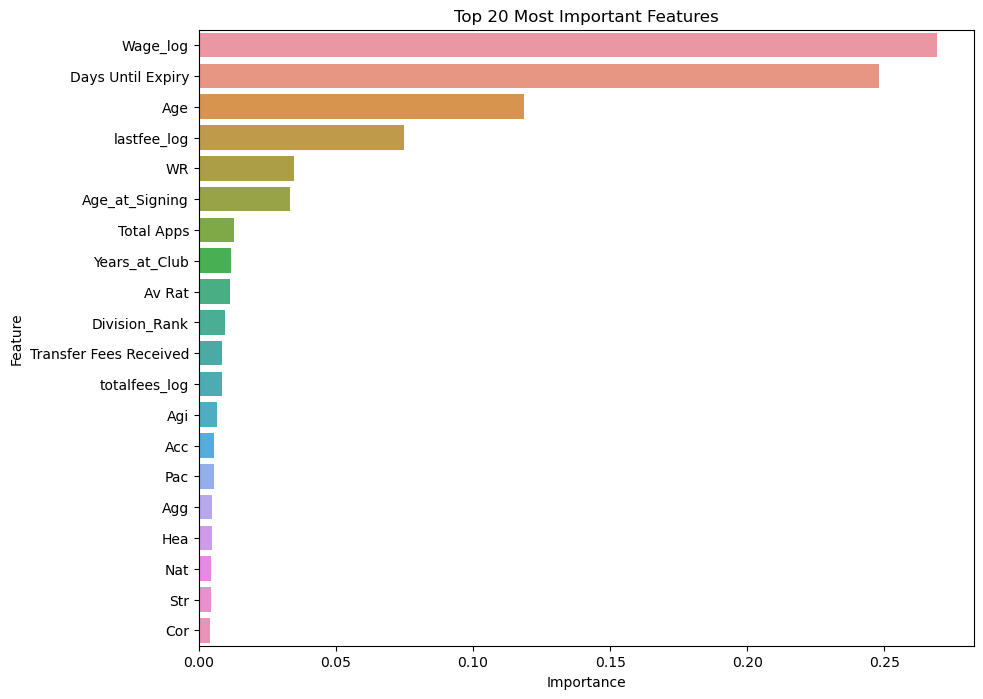

In [28]:
importancesxgb = xgb_model.feature_importances_

feature_importance_xgb_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb_df.head(20))
plt.title('Top 20 Most Important Features')
plt.show()

In [29]:
# Define the grid of hyperparameters to search
# Using distributions for some parameters allows for a finer search
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

#Set up the Randomized Search
xgb_random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid_xgb,
    n_iter=50,          # Number of parameter settings that are sampled
    cv=3,               # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#Fit the random search model
xgb_random_search.fit(x_train, y_train)

print("\nBest XGBoost parameters found:")
print(xgb_random_search.best_params_)

best_xgb = xgb_random_search.best_estimator_
y_pred_log_best_xgb = best_xgb.predict(x_test)

y_test_original = np.expm1(y_test)
y_pred_original_best_xgb = np.expm1(y_pred_log_best_xgb)

mae_original_best_xgb = mean_absolute_error(y_test_original, y_pred_original_best_xgb)
print("\n--- Tuned XGBoost Performance on Original Scale ---")
print(f"New Mean Absolute Error (MAE): £{mae_original_best_xgb:.2f}M")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best XGBoost parameters found:
{'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

--- Tuned XGBoost Performance on Original Scale ---
New Mean Absolute Error (MAE): £5.24M


In [30]:
def process_player_data(df):
    """
    Applies cleaning and feature transformation steps from the initial analysis
    to a player dataset.
    
    Args:
        df (pd.DataFrame): Raw dataframe for a specific position.
        
    Returns:
        pd.DataFrame: Cleaned and transformed dataframe.
    """
    df_clean = df.copy()
    
    financial_cols = ['Transfer Value', 'Wage', 'Last Trans. Fee']
    for col in financial_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(0)
            
    if 'Av Rat' in df_clean.columns:
        df_clean['Av Rat'] = pd.to_numeric(df_clean['Av Rat'], errors='coerce')
        df_clean['Av Rat'] = df_clean['Av Rat'].fillna(6.7)

    date_derived_features = ['Days Until Expiry', 'Age_at_Signing', 'Years_at_Club']
    for col in date_derived_features:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(0)

    if 'Transfer Value' in df_clean.columns:
        df_clean['Value_log'] = np.log1p(df_clean['Transfer Value'])

    if 'Wage' in df_clean.columns:
        df_clean['Wage_log'] = np.log1p(df_clean['Wage'])

    if 'Last Trans. Fee' in df_clean.columns:
        df_clean['lastfee_log'] = np.log1p(df_clean['Last Trans. Fee'])

    return df_clean

# cb_df_cleaned = process_player_data(cb_df)
# fb_df_cleaned = process_player_data(fb_df)
# dm_df_cleaned = process_player_data(dm_df)

# print(cb_df_cleaned[['Name', 'Value_log', 'Wage_log']].head())

In [31]:
gk_df_clean = process_player_data(gk_df)
cb_df_clean = process_player_data(cb_df)
fb_df_clean = process_player_data(fb_df)
dm_df_clean = process_player_data(dm_df)
cm_df_clean = process_player_data(cm_df)
am_df_clean = process_player_data(am_df)
wf_df_clean = process_player_data(wf_df)
st_df_clean = process_player_data(st_df)



In [32]:
def train_valuation_model(df):
    """
    Trains a Random Forest model to predict Intrinsic Player Value.
    Excludes Wage, Contract, and Nationality to find undervalued targets.
    """
    
    excluded_cols = [
        # Targets & Money
        'Transfer Value', 'Value_log', 
        'Wage', 'Wage_log', 
        'Last Trans. Fee', 'lastfee_log', 
        'Transfer Fees Received', 'totalfees_log',
        
        # Identifiers & Text
        'Name',
        'Based', 'Division', 'Nationality', 'Country',
        'Personality', 'Position',
        
        # Contract Details
        'Expires', 'Days Until Expiry', 'Begins', 
        'Age_at_Signing', 'Years_at_Club',
        
        # Market Status 
        'Transfer Status', 'Transfer_Status_bool', 
        'Rec', 'Inf',
        
        'WR'
    ]

    country_cols = [c for c in df.columns if c.startswith('Country_')]
    excluded_cols.extend(country_cols)

    feature_cols = [c for c in df.columns 
                    if c not in excluded_cols 
                    and pd.api.types.is_numeric_dtype(df[c])]
    
    print(f"Training on {len(feature_cols)} features...")
    print(f"Top 10 Features included: {feature_cols[:10]}")
    
    X = df[feature_cols]
    y = df['Value_log'] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred_log = rf.predict(X_test)
    
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_log))
    r2 = r2_score(y_test, y_pred_log)

    importances = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf.feature_importances_
    })
    
    top_features = importances.sort_values(by='Importance', ascending=False).head(10)
    
    print(f"Model R²: {r2:.3f}")
    print(f"Mean Absolute Error (in millions of pounds): {mae:,.0f}")
    print("Top 10 Drivers of Value (Feature Importance):")
    for index, row in top_features.iterrows():
        print(f"  {row['Feature']:<15} : {row['Importance']:.4f}")
    print("-" * 40 + "\n")
    
    return rf, feature_cols

# rf_model, features_used = train_valuation_model(cb_df_clean)

In [33]:
print('Goalkeepers')
gkrf_model, gkfeatures_used = train_valuation_model(gk_df_clean)
print('\nCenter Backs')
cbrf_model, cbfeatures_used = train_valuation_model(cb_df_clean)
print('\nFull Backs')
fbrf_model, fbfeatures_used = train_valuation_model(fb_df_clean)
print('\nDefensive Midfielders')
dmrf_model, dmfeatures_used = train_valuation_model(dm_df_clean)
print('\nCentral Midfielders')
cmrf_model, cmfeatures_used = train_valuation_model(cm_df_clean)
print('\nAttacking Midfielders')
amrf_model, amfeatures_used = train_valuation_model(am_df_clean)
print('\nWingers')
wfrf_model, wffeatures_used = train_valuation_model(wf_df_clean)
print('\nStrikers')
strf_model, stfeatures_used = train_valuation_model(st_df_clean)

Goalkeepers
Training on 46 features...
Top 10 Features included: ['Age', 'Height', 'Cmd', 'Pun', 'TRO', 'Han', 'Thr', 'Ecc', 'Ref', 'Kic']
Model R²: 0.566
Mean Absolute Error (in millions of pounds): 6
Top 10 Drivers of Value (Feature Importance):
  Age             : 0.3102
  Fir             : 0.0703
  Total Apps      : 0.0422
  Thr             : 0.0339
  Cnt             : 0.0294
  Pas             : 0.0268
  Bal             : 0.0261
  Ant             : 0.0259
  Division_Rank   : 0.0241
  Pos             : 0.0234
----------------------------------------


Center Backs
Training on 42 features...
Top 10 Features included: ['Age', 'Height', 'Agg', 'Ant', 'Bra', 'Cmp', 'Cnt', 'Dec', 'Fla', 'Ldr']
Model R²: 0.607
Mean Absolute Error (in millions of pounds): 5
Top 10 Drivers of Value (Feature Importance):
  Age             : 0.2655
  Division_Rank   : 0.1463
  Total Apps      : 0.0452
  Ant             : 0.0442
  Av Rat          : 0.0433
  Agi             : 0.0390
  Pas             : 0.0244
 

In [34]:

def analyze_transfer_targets(df, model, min_value_ratio=1.2):
    """
    Applies the value score model to find undervalued players.
    
    Args:
        df (pd.DataFrame): The player dataframe (cleaned).
        model: The trained Random Forest model.
        min_value_ratio (float): Minimum ROI to consider (default 1.2 = 20% undervalued).
        
    Returns:
        pd.DataFrame: A dataframe containing targets sorted by their Moneyball Score.
    """

    targets = df.copy()
    
    excluded_cols = [
        'Transfer Value', 'Value_log', 'Wage', 'Wage_log', 'Last Trans. Fee', 'lastfee_log', 
        'Transfer Fees Received', 'totalfees_log', 'Name', 'Based', 'Division', 'Personality', 
        'Country', 'Position', 'Expires', 'Days Until Expiry', 'Begins', 'Age_at_Signing', 
        'Years_at_Club', 'Transfer Status', 'Transfer_Status_bool', 'WR', 'Rec', 'Inf'
    ]

    excluded_cols.extend([c for c in targets.columns if c.startswith('Country_')])
    
    feature_cols = [c for c in targets.columns 
                    if c not in excluded_cols 
                    and pd.api.types.is_numeric_dtype(targets[c])]

    predicted_log = model.predict(targets[feature_cols])
    targets['Intrinsic_Value'] = np.expm1(predicted_log)

    targets['Value_Ratio'] = targets['Intrinsic_Value'] / (targets['Transfer Value'] + 1)
    
    targets['Wage_Efficiency'] = targets['Intrinsic_Value'] / ((targets['Wage'] * 52) + 1)
    
    targets['Contract_Factor'] = np.where(targets['Days Until Expiry'] < 365, 1.25, 1.0)
    
    targets['Value_Score'] = (
        targets['Value_Ratio'] * np.log1p(targets['Wage_Efficiency']) * targets['Contract_Factor']
    )
    
    results = targets[targets['Value_Ratio'] > min_value_ratio].copy()
    
    output_cols = [
        'Name', 'Age', 'Position', 'Club', 'Based', 'Division', 'Nationality',
        'Transfer Value', 'Wage', 'Intrinsic_Value', 
        'Value_Ratio', 'Value_Score', 
        'Days Until Expiry'
    ]
    final_cols = [c for c in output_cols if c in results.columns]
    
    return results[final_cols].sort_values('Value_Score', ascending=False)

In [35]:
targets = analyze_transfer_targets(st_df_clean, strf_model)

# my_targets = targets[
#     (targets['Transfer Value'] <= 50000000) &  # Can afford fee
#     (targets['Wage'] <= 200000)                # Can afford wage
# ]

print(targets.head(10))

                  Name  Age                           Based  \
616     Matthis Abline   31      England (Premier Division)   
31       Mariano DÃ­az   24  England (Sky Bet Championship)   
862     Sergio Camello   33          Spain (First Division)   
215            Michael   24       Colombia (First Division)   
736      Leandro Soria   30                    U.S.A. (MLS)   
569    AndrÃ© Henrique   33       Norway (Premier Division)   
250       Adam Hansson   22      England (Premier Division)   
196      Trond Torvund   26                 Italy (Serie A)   
463  Maximilian Peters   23      England (Premier Division)   
239     JosÃ© Valencia   26       Colombia (First Division)   

                       Division  Transfer Value     Wage  Intrinsic_Value  \
616    English Premier Division          0.0000  83000.0        17.716362   
31         Sky Bet Championship          0.9350   9250.0         6.950265   
862      Spanish First Division          0.0000  31000.0        10.219003  

In [36]:
def analyze_market_inefficiencies(df_scored):
    """
    Aggregates player scores to find undervalued Leagues and Nations.
    
    Args:
        df_scored (pd.DataFrame): The output from analyze_transfer_targets() 
                                  (Make sure 'Based' and 'Division' are in the columns!)
                           
    Returns:
        pd.DataFrame: A report of the most undervalued markets.
    """
    
    market_stats = df_scored.groupby(['Based', 'Division']).agg({
        'Value_Ratio': ['count', 'median', 'mean'],
        'Value_Score': 'mean',
        'Wage': 'mean'  
    })
    
    market_stats.columns = [
        'Player_Count', 'Median_ROI', 'Mean_ROI', 
        'Avg_Value_Score', 'Avg_Wage'
    ]
    
    market_stats['Market_Attractiveness'] = (
        market_stats['Median_ROI'] * 10000 / (market_stats['Avg_Wage'] + 1)
    )
    
    return market_stats.sort_values('Median_ROI', ascending=False)

# scored_players = analyze_transfer_targets(cb_df, rf_model)

# best_leagues = analyze_market_inefficiencies(scored_players)

# print(best_leagues[['Player_Count', 'Median_ROI', 'Avg_Wage']].head(10))

In [37]:
scored_pos = analyze_transfer_targets(cm_df_clean, cmrf_model)

best_leagues = analyze_market_inefficiencies(scored_pos)

print(best_leagues[['Player_Count', 'Median_ROI', 'Avg_Wage']].sort_values(by='Player_Count', ascending=False).head(10))

                                                           Player_Count  \
Based                          Division                                   
Italy (Serie A)                Italian Serie A                        8   
Norway (Premier Division)      Norwegian Premier Division             7   
Spain (First Division)         Spanish First Division                 5   
England (Premier Division)     English Premier Division               5   
England (Sky Bet Championship) Sky Bet Championship                   4   
Belgium (Jupiler Pro League)   Jupiler Pro League                     3   
France (Ligue 1 Uber Eats)     Ligue 1 Uber Eats                      3   
Netherlands (Eredivisie)       Eredivisie                             3   
Switzerland (Super League)     Swiss Super League                     2   
Germany (Bundesliga 2)         Bundesliga 2                           2   

                                                           Median_ROI  \
Based                     

In [38]:
import joblib
import os

if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

models_to_save = {
    'gk_model': gkrf_model,   
    'cb_model': cbrf_model, 
    'fb_model': cbrf_model,  
    'dm_model': cbrf_model,   
    'cm_model': cbrf_model,   
    'am_model': strf_model, 
    'wf_model': cbrf_model,  
    'st_model': cmrf_model 
}

for name, model in models_to_save.items():
    path = f'saved_models/{name}.pkl'
    joblib.dump(model, path)
    print(f"Saved {name} to {path}")

Saved gk_model to saved_models/gk_model.pkl
Saved cb_model to saved_models/cb_model.pkl
Saved fb_model to saved_models/fb_model.pkl
Saved dm_model to saved_models/dm_model.pkl
Saved cm_model to saved_models/cm_model.pkl
Saved am_model to saved_models/am_model.pkl
Saved wf_model to saved_models/wf_model.pkl
Saved st_model to saved_models/st_model.pkl
